In [164]:
import polars as pl
import numpy as np

from matplotlib import pyplot as plt
from seaborn import pairplot, barplot, violinplot
from plotly import graph_objects as go
from statsmodels.graphics.tsaplots import plot_acf

from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import norm
from scipy.stats import fligner

## Field Definitions

<center>

| Feature Name              | Description                                                                                   |
|---------------------------|-----------------------------------------------------------------------------------------------|
| **Campaign Name**          | The title of the campaign being analyzed (either Control Campaign or Test Campaign).          |
| **Date**                   | The date on which the record was captured.                                                    |
| **Spend ($)**              | The total amount of money spent on the campaign, measured in dollars.                         |
| **Impressions (#)**        | The number of times the ad was shown across the campaign (non-unique).                        |
| **Reach (#)**              | The number of unique individuals who viewed the ad at least once during the campaign.         |
| **Website Clicks (#)**     | The number of times users clicked on the website link from the ads.                           |
| **Searches (#)**           | The number of users who performed a search on the website after interacting with the ad.      |
| **Content Views (#)**      | The number of users who viewed content or product pages on the website.                       |
| **Add to Cart (#)**        | The number of users who added products to their cart after viewing the ad.                    |
| **Purchases (#)**          | The number of purchases made as a result of the campaign.                                     |

</center>

### Notes

- **Impressions**: The total number of times an ad is displayed to users (can include multiple views by the same individual).
- **Unique Impressions (Reach)**: The number of distinct users who have seen the ad at least once.
- **In Google Ads**: Impressions are logged each time an ad is shown, whereas views are tracked when someone engages with the web page content.

### Data Source

This data comes from [Kaggle: AB Testing Dataset by Amir Motefaker](https://www.kaggle.com/datasets/amirmotefaker/ab-testing-dataset).

In [165]:
data = pl.read_parquet("../data/campaigns.parquet")

data.shape

(60, 10)

In [166]:
data

campaign_name,date,spend_usd,impressions_count,reach,website_clicks_count,searches_count,view_content_count,add_to_cart_count,purchase_count
cat,datetime[ns],i16,i32,i32,i32,i32,i32,i32,i32
"""Control Campaign""",2019-01-08 00:00:00,2280,82702,56930,7016,2290,2159,1819,618
"""Control Campaign""",2019-02-08 00:00:00,1757,121040,102513,8110,2033,1841,1219,511
"""Control Campaign""",2019-03-08 00:00:00,2343,131711,110862,6508,1737,1549,1134,372
"""Control Campaign""",2019-04-08 00:00:00,1940,72878,61235,3065,1042,982,1183,340
"""Control Campaign""",2019-05-08 00:00:00,1835,null,null,null,null,null,null,null
…,…,…,…,…,…,…,…,…,…
"""Test Campaign""",2019-08-26 00:00:00,2311,80841,61589,3820,2037,1046,346,284
"""Test Campaign""",2019-08-27 00:00:00,2915,111469,92159,6435,2976,2552,992,771
"""Test Campaign""",2019-08-28 00:00:00,2247,54627,41267,8144,2432,1281,1009,721


In [167]:
group_col = "campaign_name"
date_col = "date"

num_cols = [col for col in data.columns if col.endswith("count")] + [
    "reach",
    "spend_usd",
]

## Descriptive Statistics

### Control Campaign

In [168]:
data.filter(pl.col(group_col) == "Control Campaign").describe()

statistic,campaign_name,date,spend_usd,impressions_count,reach,website_clicks_count,searches_count,view_content_count,add_to_cart_count,purchase_count
str,str,str,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""30""","""30""",30.0,29.0,29.0,29.0,29.0,29.0,29.0,29.0
"""null_count""","""0""","""0""",0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
"""mean""",null,"""2019-07-28 21:36:00""",2288.433333,109559.758621,88844.931034,5320.793103,2221.310345,1943.793103,1300.0,522.793103
"""std""",null,null,367.334451,21688.922908,21832.349595,1757.369003,866.089368,777.545469,407.457973,185.028642
"""min""",null,"""2019-01-08 00:00:00""",1757.0,71274.0,42859.0,2277.0,1001.0,848.0,442.0,222.0
"""25%""",null,"""2019-08-08 00:00:00""",1940.0,92029.0,74192.0,4085.0,1615.0,1249.0,930.0,372.0
"""50%""",null,"""2019-08-20 00:00:00""",2319.0,113430.0,91579.0,5224.0,2390.0,1984.0,1339.0,501.0
"""75%""",null,"""2019-08-27 00:00:00""",2544.0,121332.0,102479.0,6628.0,2711.0,2421.0,1641.0,670.0
"""max""",null,"""2019-12-08 00:00:00""",3083.0,145248.0,127852.0,8137.0,4891.0,4219.0,1913.0,800.0


### Test Campaign

In [169]:
data.filter(pl.col(group_col) == "Test Campaign").describe()

statistic,campaign_name,date,spend_usd,impressions_count,reach,website_clicks_count,searches_count,view_content_count,add_to_cart_count,purchase_count
str,str,str,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""30""","""30""",30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0
"""null_count""","""0""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",null,"""2019-07-28 21:36:00""",2563.066667,74584.8,53491.566667,6032.333333,2418.966667,1858.0,881.533333,521.233333
"""std""",null,null,348.687681,32121.377422,28795.775752,1708.567263,388.742312,597.654669,347.584248,211.047745
"""min""",null,"""2019-01-08 00:00:00""",1968.0,22521.0,10598.0,3038.0,1854.0,858.0,278.0,238.0
"""25%""",null,"""2019-08-08 00:00:00""",2311.0,45511.0,31489.0,4399.0,2037.0,1281.0,566.0,284.0
"""50%""",null,"""2019-08-20 00:00:00""",2626.0,70263.0,45198.0,6435.0,2432.0,1894.0,992.0,512.0
"""75%""",null,"""2019-08-27 00:00:00""",2838.0,100719.0,79632.0,7617.0,2824.0,2427.0,1168.0,709.0
"""max""",null,"""2019-12-08 00:00:00""",3112.0,133771.0,109834.0,8264.0,2978.0,2801.0,1391.0,890.0


### Sampling Period

In [170]:
# Plot the sampling periods for each campaign
data.group_by(group_col).agg(
    [pl.min(date_col).alias("start"), pl.max(date_col).alias("end")]
)

campaign_name,start,end
cat,datetime[ns],datetime[ns]
"""Test Campaign""",2019-01-08 00:00:00,2019-12-08 00:00:00
"""Control Campaign""",2019-01-08 00:00:00,2019-12-08 00:00:00


### Scatter Plot Matrix

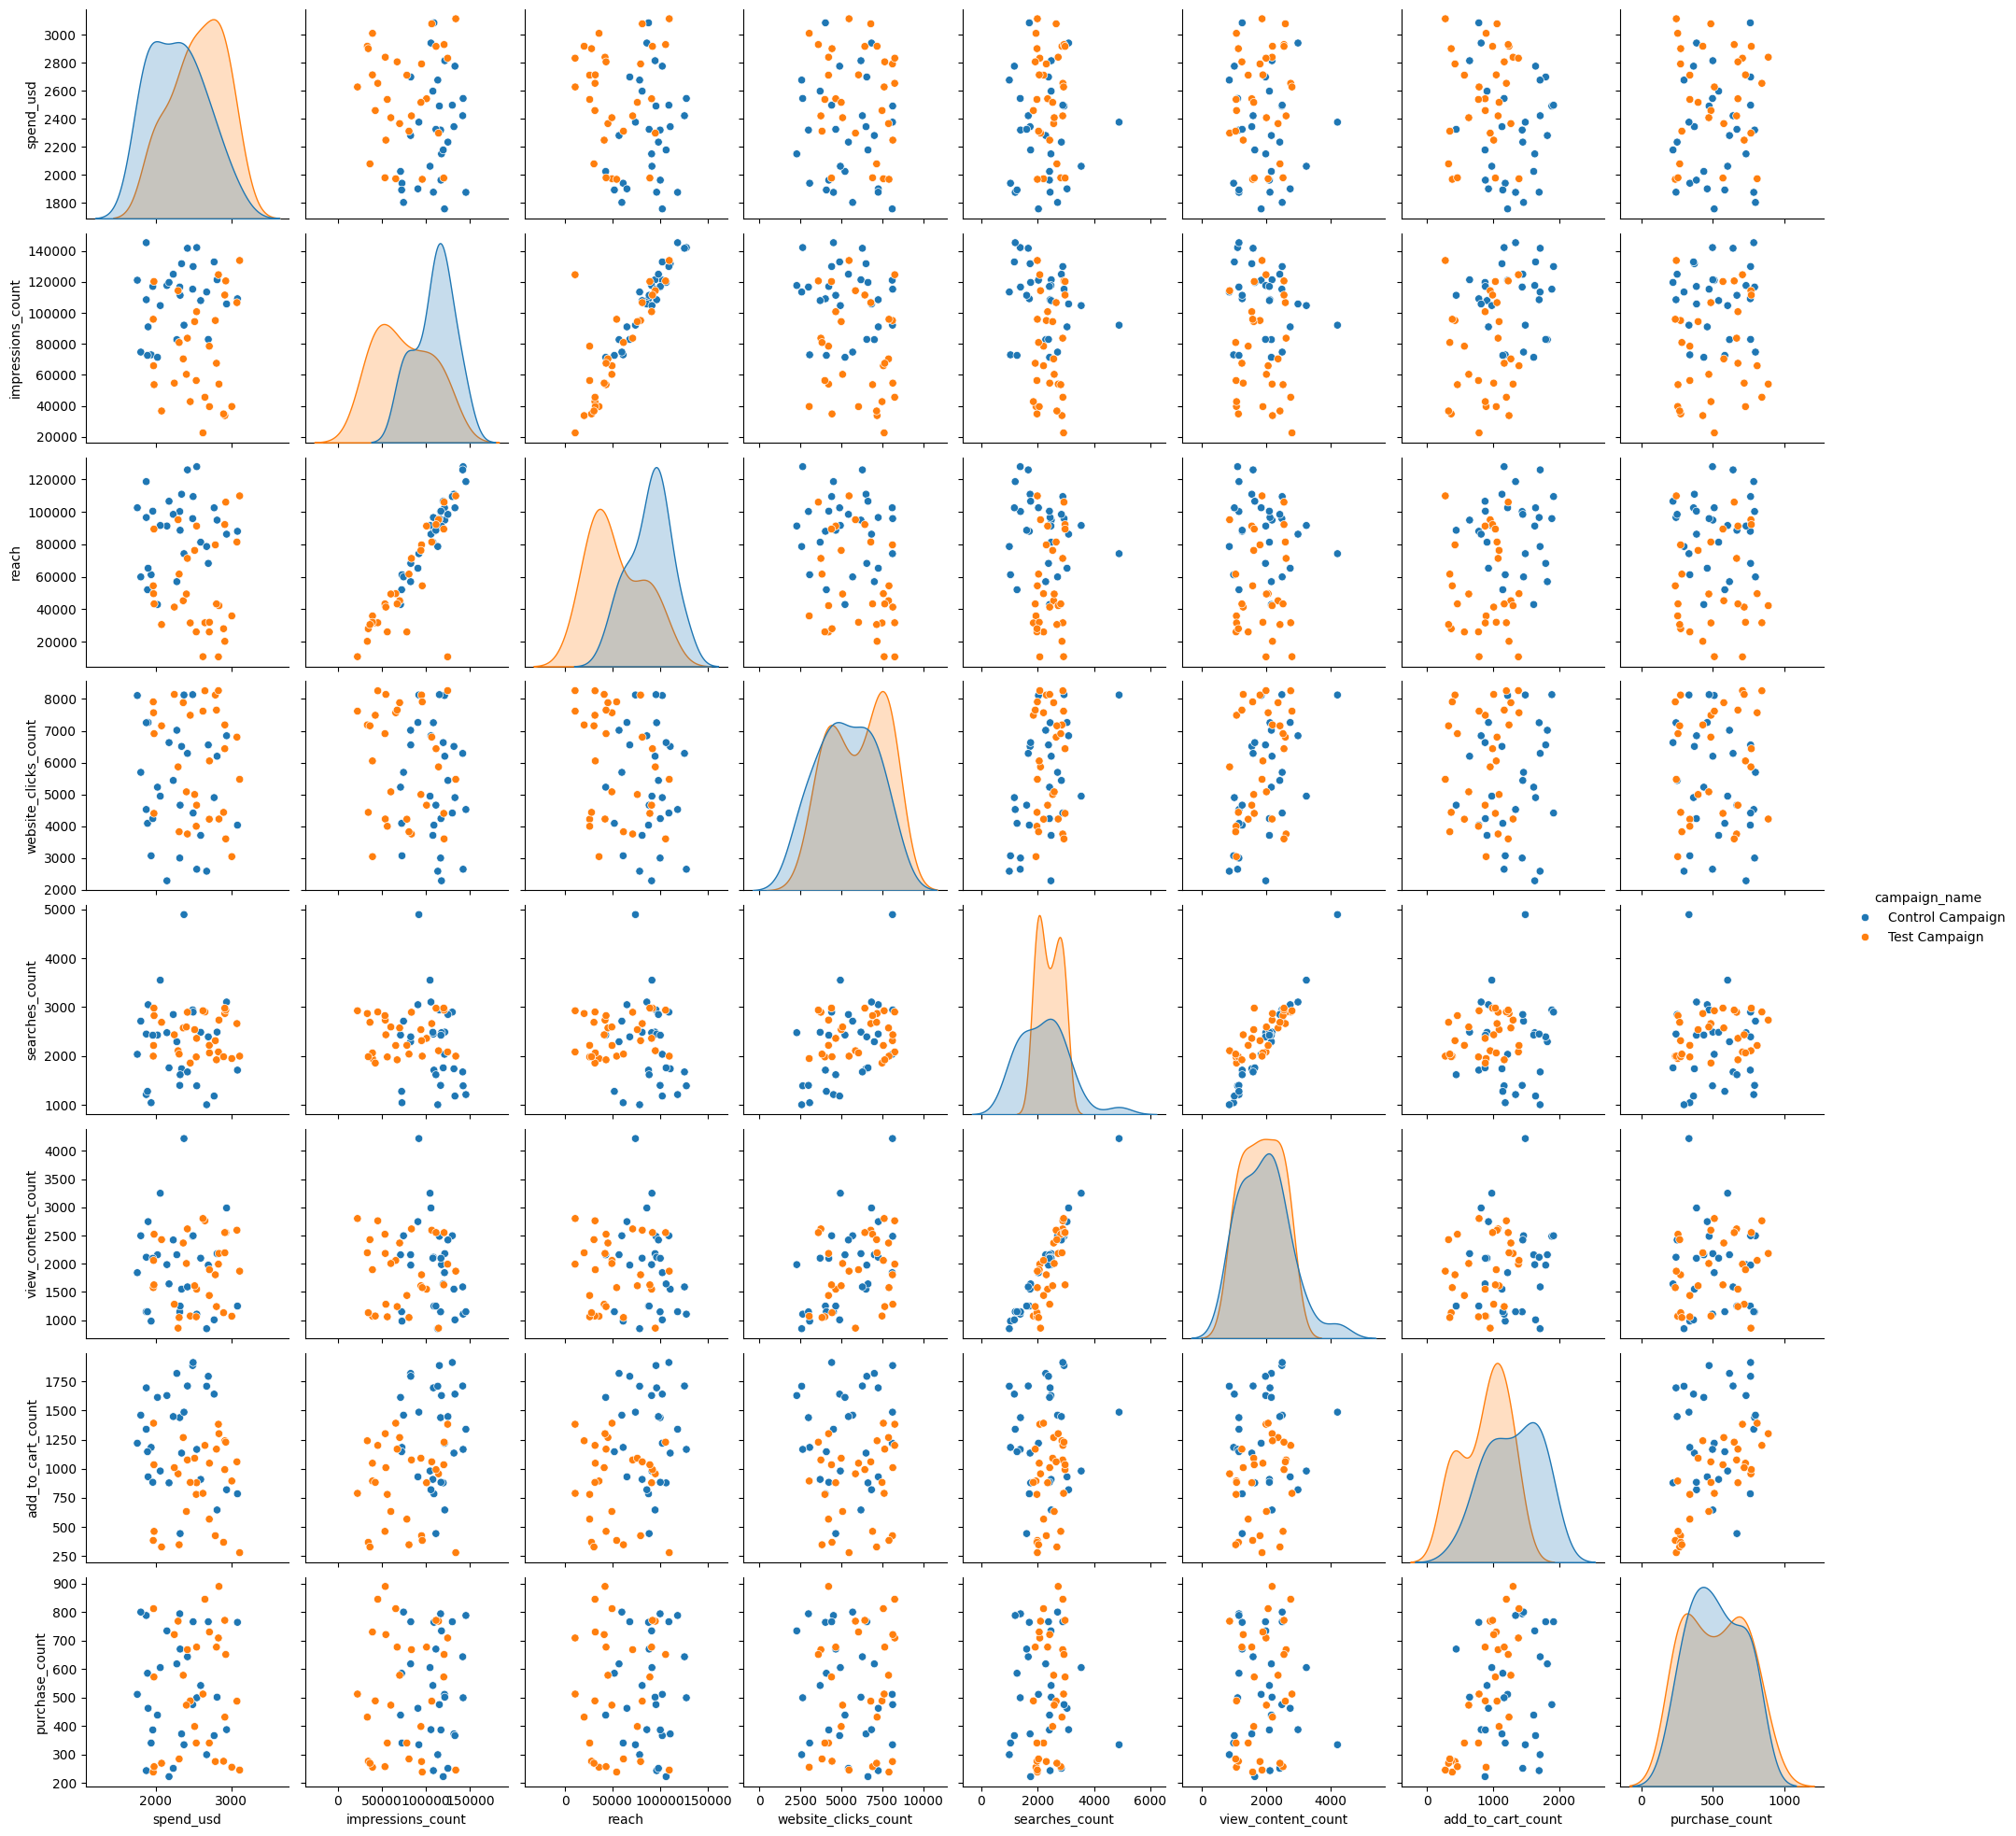

In [171]:
# Scatter plot matrix for the counts columns
pairplot(
    data=data.to_pandas(),
    hue=group_col,
)

### Bar Plot

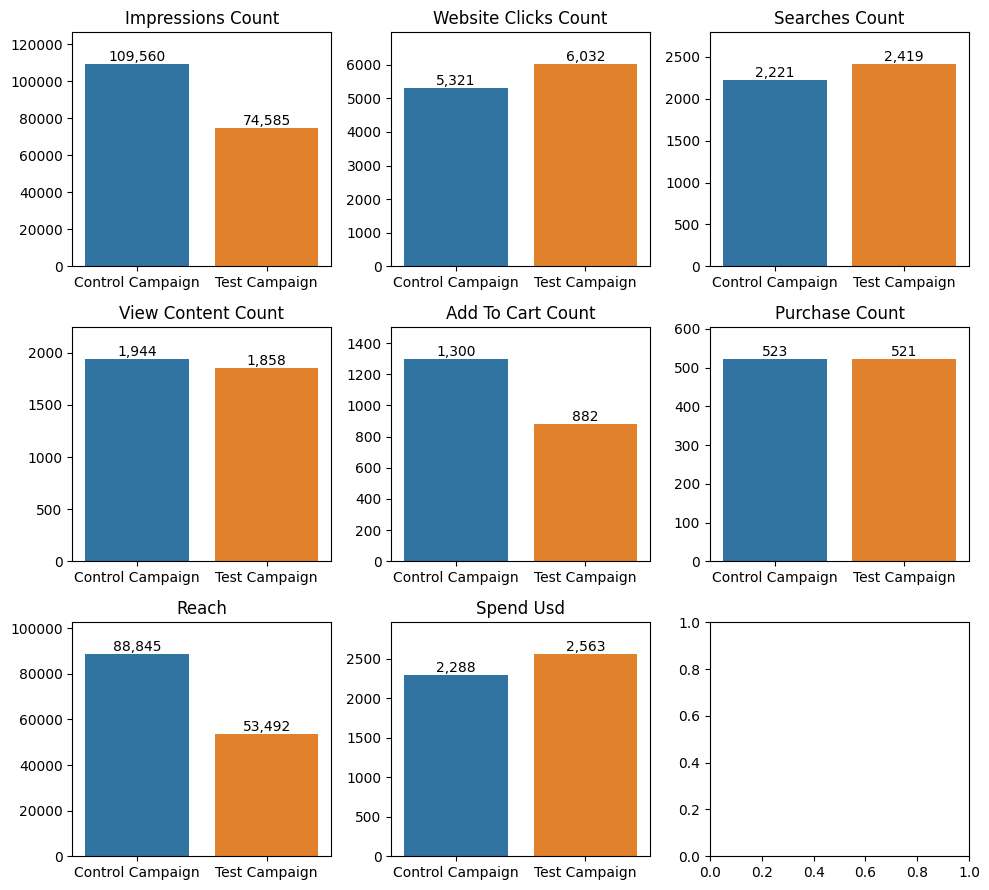

In [172]:
fig, axes = plt.subplots(3, 3, figsize=(10, 9))

for i, col in enumerate(num_cols):
    ax = axes[i // 3, i % 3]
    barplot(
        data=data.select([group_col, col]).to_pandas(),
        x=group_col,
        y=col,
        hue=group_col,
        dodge=False,
        ax=ax,
        errorbar=None,
    )
    # Set title and replace underscores with spaces
    ax.set_title(col.title().replace("_", " "))
    ax.set_xlabel("")
    ax.set_ylabel("")
    # Adjust y-axis limit to create space for labels
    ax.set_ylim(
        0, ax.get_ylim()[1] * 1.1
    )  # Add 10% padding to the top of the tallest bar

    # Add labels on top of the bars with thousand separators
    for container in ax.containers:
        ax.bar_label(container, fmt="{:,.0f}", label_type="edge")

plt.tight_layout()
plt.show();

### Violin Plot

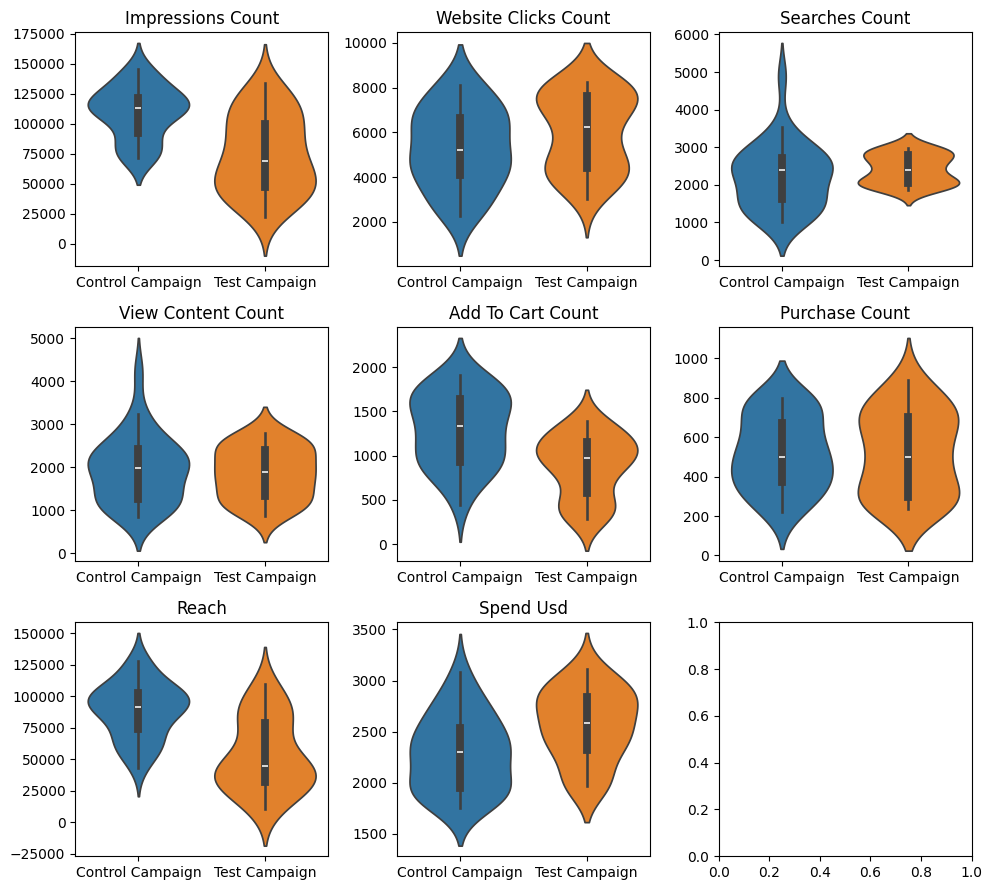

In [173]:
fig, axes = plt.subplots(3, 3, figsize=(10, 9))

for i, col in enumerate(num_cols):
    ax = axes[i // 3, i % 3]
    violinplot(
        data=data.select([group_col, col]).to_pandas(),
        x=group_col,
        y=col,
        hue=group_col,
        dodge=False,
        ax=ax,
    )
    ax.set_title(col.title().replace("_", " "))
    ax.set_xlabel("")
    ax.set_ylabel("")

plt.tight_layout()
plt.show();

## Funnel Analysis

In [174]:
funnel_cols = [
    "impressions_count",
    "website_clicks_count",
    "add_to_cart_count",
    "purchase_count",
]

In [175]:
funnel_data = (
    data.select([group_col] + funnel_cols)
    .group_by(group_col)
    .agg(
        (pl.sum("impressions_count") / 1000).alias("total_impressions"),
        (pl.sum("website_clicks_count") / 1000).alias("total_website_clicks"),
        (pl.sum("add_to_cart_count") / 1000).alias("total_add_to_cart"),
        (pl.sum("purchase_count") / 1000).alias("total_purchases"),
    )
    .rename({group_col: "stage"})
    .unpivot(
        index="stage",
        on=[
            "total_impressions",
            "total_website_clicks",
            "total_add_to_cart",
            "total_purchases",
        ],
        variable_name="metric",
        value_name="value",
    )
    .pivot(values="value", index="metric", on="stage", aggregate_function=None)
)

funnel_data

metric,Control Campaign,Test Campaign
str,f64,f64
"""total_impressions""",3177.233,2237.544
"""total_website_clicks""",154.303,180.97
"""total_add_to_cart""",37.7,26.446
"""total_purchases""",15.161,15.637


In [176]:
metrics = [
    metric.title().replace("_", " ") for metric in funnel_data["metric"].to_list()
]

fig = go.Figure()

fig.update_layout(title_text="Marketing Funnel By Campaign (Units in Thousands)")

fig.add_trace(
    go.Funnel(
        name="Control Campaign",
        y=metrics,
        x=funnel_data["Control Campaign"].to_list(),
        textinfo="value+percent initial",
    )
)

fig.add_trace(
    go.Funnel(
        name="Test Campaign",
        y=metrics,
        x=funnel_data["Test Campaign"].to_list(),
        textinfo="value+percent initial",
    )
)

fig.show();

## Independence

### Independence Within Each Campaign

#### Test Campaign

In [143]:
test_campaign = {}
for col in num_cols:
    test_campaign[col] = (
        data.filter(pl.col(group_col) == "Test Campaign")
        .select(pl.all().forward_fill())[col]
        .to_numpy()
    )

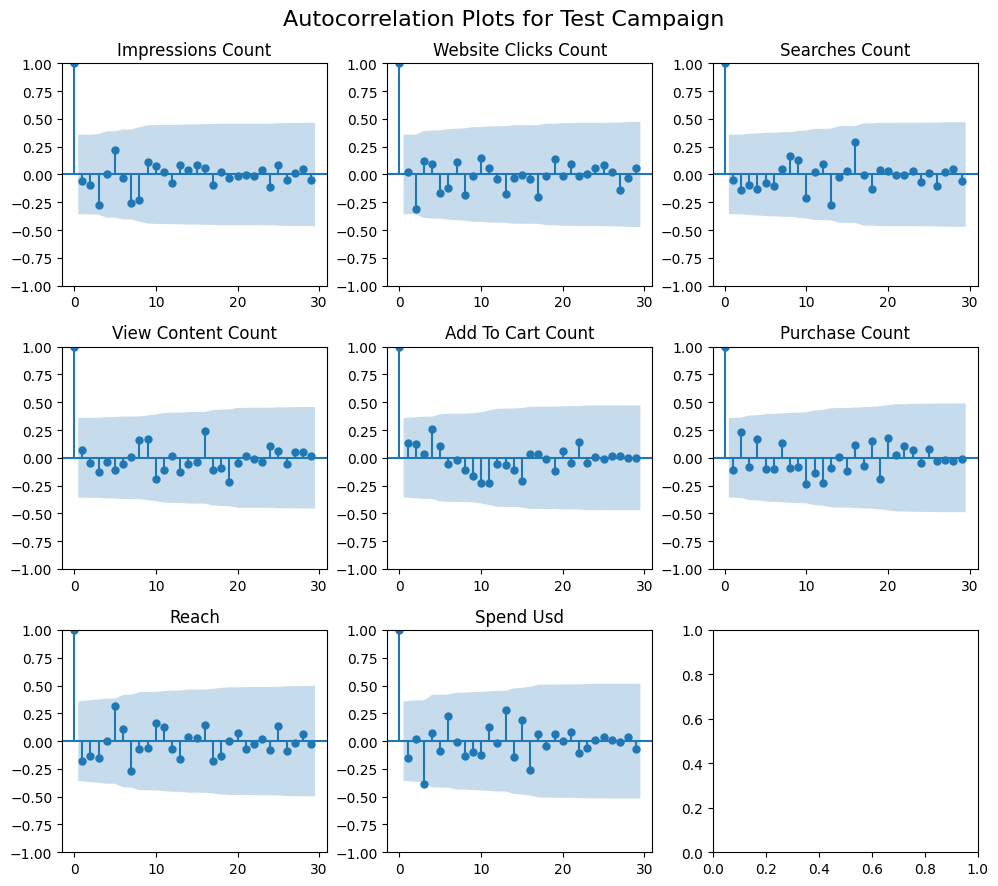

In [144]:
fig, axes = plt.subplots(3, 3, figsize=(10, 9))

for i, (col, metric) in enumerate(test_campaign.items()):
    ax = axes[i // 3, i % 3]
    num_lags = np.count_nonzero(~np.isnan(metric)) - 1
    plot_acf(
        x=metric,
        ax=ax,
        lags=num_lags,  # Number of lags to show
        alpha=0.05,  # 95% confidence intervals
        fft=True,  # Use FFT for faster computation
        title=col.title().replace("_", " "),
    )
    ax.set_xlabel("")
    ax.set_ylabel("")

fig.suptitle("Autocorrelation Plots for Test Campaign", fontsize=16)

plt.tight_layout()
plt.show();

In [161]:
for col, metric in test_campaign.items():
    p_value = acorr_ljungbox(metric, auto_lag=True, return_df=False)[
        "lb_pvalue"
    ].values[0]
    print(
        f"{col}: p-value = {p_value:.4f} | {'Reject' if p_value < 0.05 else 'Fail to reject'} the null hypothesis of independence\n"
    )

impressions_count: p-value = 0.7367 | Fail to reject the null hypothesis of independence

website_clicks_count: p-value = 0.9053 | Fail to reject the null hypothesis of independence

searches_count: p-value = 0.7812 | Fail to reject the null hypothesis of independence

view_content_count: p-value = 0.6832 | Fail to reject the null hypothesis of independence

add_to_cart_count: p-value = 0.4313 | Fail to reject the null hypothesis of independence

purchase_count: p-value = 0.5179 | Fail to reject the null hypothesis of independence

reach: p-value = 0.3034 | Fail to reject the null hypothesis of independence

spend_usd: p-value = 0.3736 | Fail to reject the null hypothesis of independence



#### Control Campaign

In [146]:
control_campaign = {}
for col in num_cols:
    control_campaign[col] = (
        data.filter(pl.col(group_col) == "Control Campaign")
        .select(pl.all().forward_fill())[col]
        .to_numpy()
    )

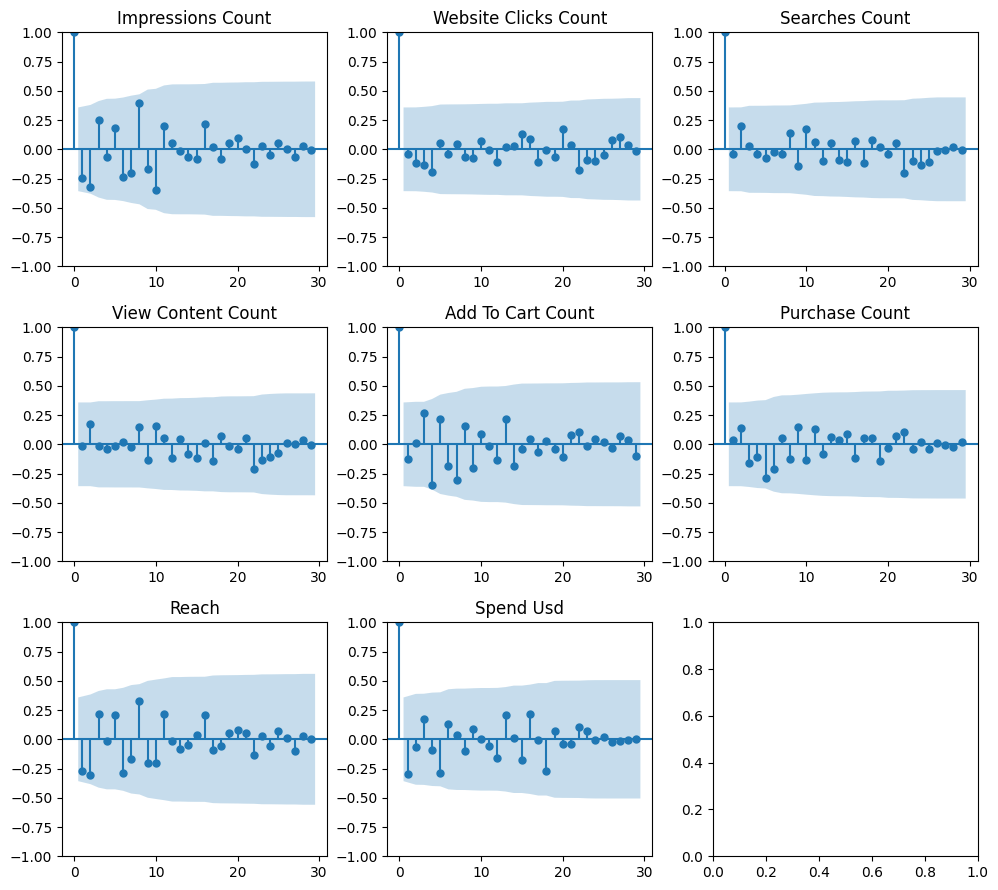

In [147]:
fig, axes = plt.subplots(3, 3, figsize=(10, 9))

for i, (col, metric) in enumerate(control_campaign.items()):
    ax = axes[i // 3, i % 3]
    num_lags = np.count_nonzero(~np.isnan(metric)) - 1
    plot_acf(
        x=metric,
        ax=ax,
        lags=num_lags,  # Number of lags to show
        alpha=0.05,  # 95% confidence intervals
        fft=True,  # Use FFT for faster computation
        title=col.title().replace("_", " "),
    )
    ax.set_xlabel("")
    ax.set_ylabel("")

plt.tight_layout()
plt.show()

In [160]:
for col, metric in control_campaign.items():
    p_value = acorr_ljungbox(metric, auto_lag=True, return_df=False)[
        "lb_pvalue"
    ].values[0]
    print(
        f"{col}: p-value = {p_value:.4f} | {'Reject' if p_value < 0.05 else 'Fail to reject'} the null hypothesis of independence\n"
    )

impressions_count: p-value = nan | Fail to reject the null hypothesis of independence

website_clicks_count: p-value = nan | Fail to reject the null hypothesis of independence

searches_count: p-value = nan | Fail to reject the null hypothesis of independence

view_content_count: p-value = nan | Fail to reject the null hypothesis of independence

add_to_cart_count: p-value = nan | Fail to reject the null hypothesis of independence

purchase_count: p-value = nan | Fail to reject the null hypothesis of independence

reach: p-value = nan | Fail to reject the null hypothesis of independence

spend_usd: p-value = 0.0867 | Fail to reject the null hypothesis of independence



### Independence Between Campaigns

In [149]:
def plot_ccf(
    x: np.ndarray, y: np.ndarray, maxlags: int, title: str, ci: float = 0.95, ax=None
) -> None:
    """
    Plot the cross-correlation between two time series.

    Parameters
    ----------
    x : np.ndarray
        The first time series.
    y : np.ndarray
        The second time series.
    maxlags : int
        The maximum number of lags to plot.
    title : str
        The title of the plot.
    ci : float, optional
        The confidence interval, by default 0.95.
    ax : plt.Axes, optional
        The axes to plot the figure on, by default None.
    """
    # Standardize both time series
    x_standardized = (x - x.mean()) / x.std()
    y_standardized = (y - y.mean()) / y.std()

    # CI for white noise
    ci_lim = norm.ppf((1 + ci) / 2) / np.sqrt(len(x))

    # Plot cross-correlation
    ax.xcorr(x=x_standardized, y=y_standardized, maxlags=maxlags)
    ax.axhline(
        ci_lim,
        color="blue",
        linestyle="--",
        label=f"{ci*100}% Significance Level (White Noise)",
    )
    ax.axhline(-ci_lim, color="blue", linestyle="--")
    ax.set_title(title)
    ax.set_xlabel("Lag")

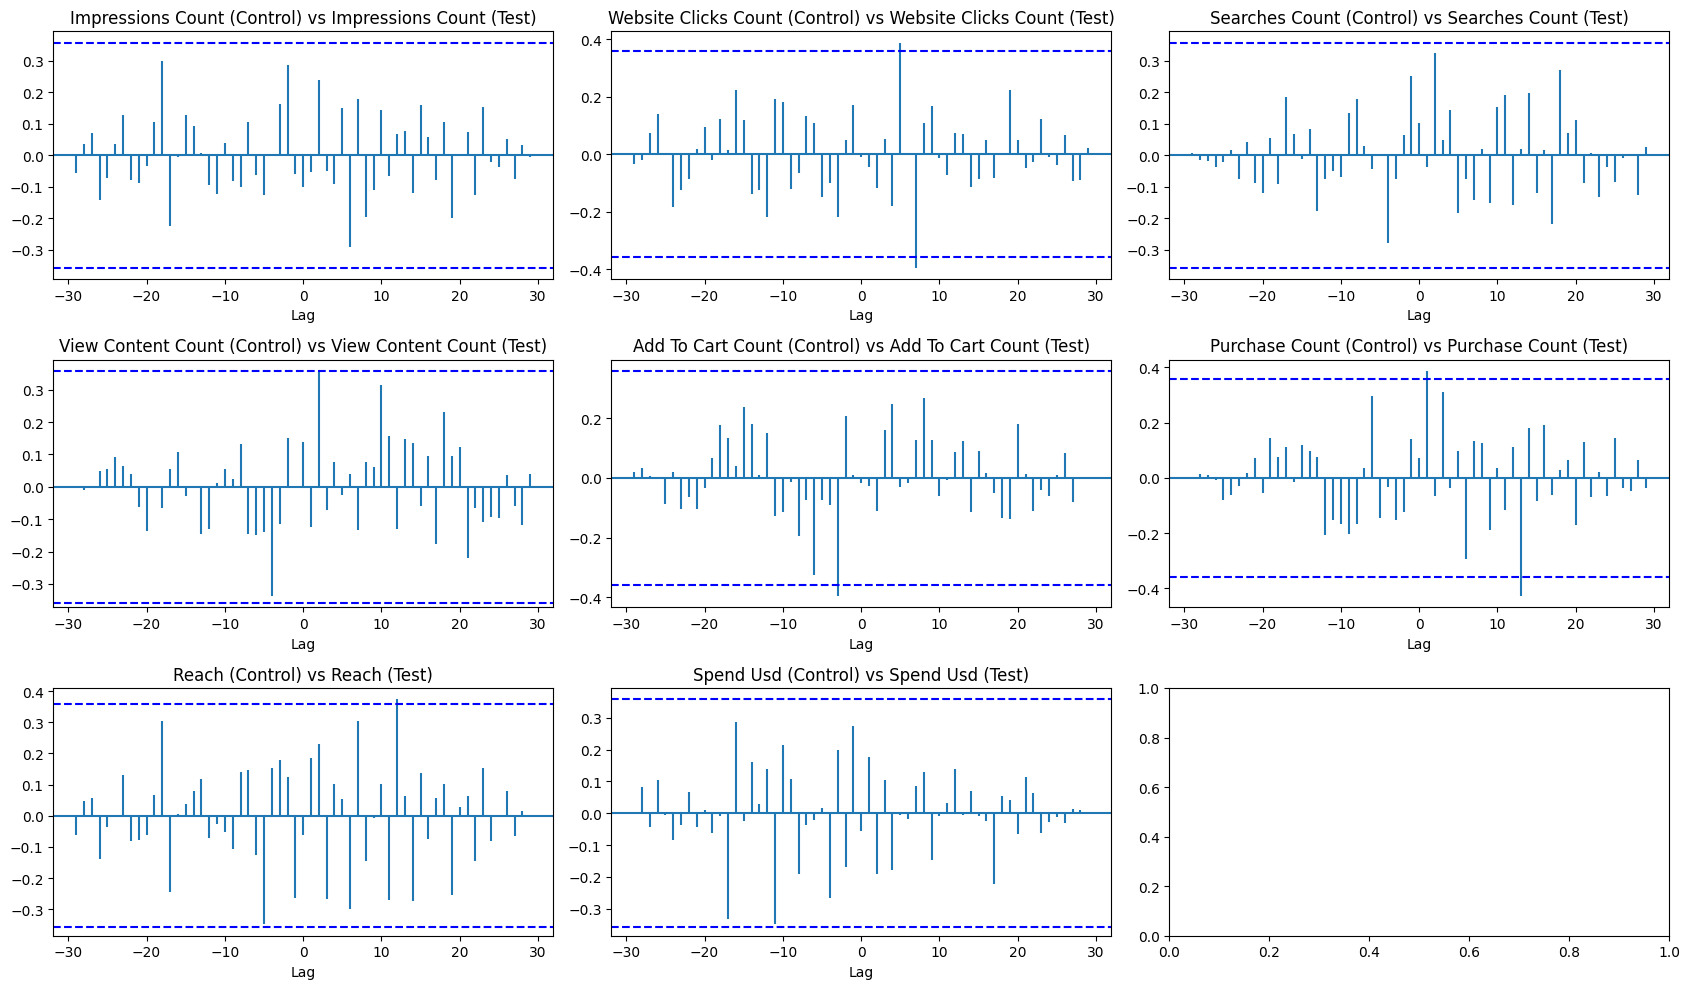

In [126]:
fig, axes = plt.subplots(3, 3, figsize=(17, 10))

for i, ((col_control, metric_control), (col_test, metric_test)) in enumerate(
    zip(control_campaign.items(), test_campaign.items())
):
    ax = axes[i // 3, i % 3]
    plot_ccf(
        x=metric_control,
        y=metric_test,
        maxlags=len(metric_control) - 1,
        title=f"{col_control.title().replace('_', ' ')} (Control) vs {col_test.title().replace('_', ' ')} (Test)",
        ax=ax,
    )

plt.tight_layout()
plt.show();

## Fligner-Killeen Test for Equality of Variance

In [177]:
campain_data = {
    "control": {
        col: data.filter(pl.col(group_col) == "Control Campaign")[col].to_numpy()
        for col in num_cols
    },
    "test": {
        col: data.filter(pl.col(group_col) == "Test Campaign")[col].to_numpy()
        for col in num_cols
    },
}

In [178]:
for (col_control, metric_control), (col_test, metric_test) in zip(
    campain_data["control"].items(), campain_data["test"].items()
):
    fligner_res = fligner(
        control_campaign["impressions_count"],
        test_campaign["impressions_count"],
        center="median",
        proportiontocut=0.05,
        nan_policy="omit",
    )
    p_value = fligner_res.pvalue
    print(
        f"{col_control} vs {col_test}: p-value = {p_value:.4f} | {'Reject' if p_value < 0.05 else 'Fail to reject'} the null hypothesis of equal variances\n"
    )

impressions_count vs impressions_count: p-value = 0.0116 | Reject the null hypothesis of equal variances

website_clicks_count vs website_clicks_count: p-value = 0.0116 | Reject the null hypothesis of equal variances

searches_count vs searches_count: p-value = 0.0116 | Reject the null hypothesis of equal variances

view_content_count vs view_content_count: p-value = 0.0116 | Reject the null hypothesis of equal variances

add_to_cart_count vs add_to_cart_count: p-value = 0.0116 | Reject the null hypothesis of equal variances

purchase_count vs purchase_count: p-value = 0.0116 | Reject the null hypothesis of equal variances

reach vs reach: p-value = 0.0116 | Reject the null hypothesis of equal variances

spend_usd vs spend_usd: p-value = 0.0116 | Reject the null hypothesis of equal variances



We reject the null hypotheses that the variances are equal for all features.